# Extraemos más información a través de NLP

In [1]:
%pip install gensim

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import re
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
import wordpreproc as wp
import nltk
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

import seaborn as sns
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models import HdpModel


In [3]:
full_data = pd.read_csv("../data/processed/balanced_train.csv",index_col=0).reset_index(drop=True)
highschool_files = full_data.query("target == 0").iloc[:,0]
college_files = full_data.query("target == 1").iloc[:,0]
adult_files = full_data.query("target == 2").iloc[:,0]
adult_files

800     person british accent suppose see something wa...
801     jane sister law stay home maribeth school frie...
802     either bride dress gold white watch bride get ...
803     imprison men wait die nasty thing torture alon...
804     birth home parent new home know daddy die rest...
                              ...                        
1195    female friend invite dinner show idea commerci...
1196    theater rehearse play write purchase costume j...
1197    get ready take matthew hospital surgery bill g...
1198    train depot son nephew tell nephew sure buy gi...
1199    barry apartment wake morning bed listen daught...
Name: text_cleaned, Length: 400, dtype: object

In [4]:
# Inicializamos preprocesamiento para futuras predicciones
new_prep = wp.WordPrep()
new_prep.update_stopwords()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/manuel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# Cargamos el mejor modelo entrenado anteriormente (3_modelling)
with open('../model/modelomulnb.model', "rb") as archivo_entrada:
    model_mulnb = pickle.load(archivo_entrada)

In [6]:
adult_files

800     person british accent suppose see something wa...
801     jane sister law stay home maribeth school frie...
802     either bride dress gold white watch bride get ...
803     imprison men wait die nasty thing torture alon...
804     birth home parent new home know daddy die rest...
                              ...                        
1195    female friend invite dinner show idea commerci...
1196    theater rehearse play write purchase costume j...
1197    get ready take matthew hospital surgery bill g...
1198    train depot son nephew tell nephew sure buy gi...
1199    barry apartment wake morning bed listen daught...
Name: text_cleaned, Length: 400, dtype: object

# TF-IDF / Palabras más relevantes

In [7]:
# Analísis a través del TF-IDF

from sklearn.feature_extraction.text import TfidfVectorizer

tv = TfidfVectorizer(use_idf=True)
tv_matrix = tv.fit_transform(adult_files)
tv_matrix = tv_matrix.toarray()

vocab = tv.get_feature_names_out()
tfidf_df = pd.DataFrame(np.round(tv_matrix, 2), columns = vocab)
tfidf_df.sum().sort_values(ascending=False).head(20)
df_idf = pd.DataFrame(tv.idf_, index=tv.get_feature_names_out(),columns=["idf_weights"])
df_idf.sort_values(by=['idf_weights']).head(20)

,idf_weights
get,1.534376
go,1.573426
say,1.690657
one,1.768215
think,1.801005
like,1.875968
know,1.888016
something,1.894095
come,1.918788
look,1.937716


In [8]:
tfidf_df = pd.DataFrame(np.round(tv_matrix, 2), columns = vocab)
tfidf_df.sum().sort_values(ascending=False).head(20)

go           22.05
get          19.78
say          17.23
one          15.35
think        12.49
like         11.31
something    11.06
know         10.65
look         10.65
come         10.54
try          10.45
tell         10.28
back         10.21
house        10.12
car           9.57
woman         9.38
people        9.27
would         9.24
see           9.01
work          8.79
dtype: float64

In [9]:
def visualize_word_freq(input_data,max_words,title_pre,tfidf=True,color='orange'):
    """
    visualize_word_freq(input_data,max_words,title_pre,tfidf=True,color='orange') --> plots via pd
    
    Visualiza las palabras más relevantes según el TF-IDF o según su ocurrencia (CounVectorizer)

    """
    plt.style.use("ggplot")
    plt.rcParams['axes.titlesize'] = 32
    plt.rcParams['figure.figsize'] = (20.0, 5.0)
    plt.rcParams['xtick.labelsize'] = 22
    
    if tfidf:
        vectorizer = TfidfVectorizer(max_features=max_words,use_idf=True,stop_words='english')
        TITLE = title_pre+" - "+"Palabras más frecuentes (TFIDF)"
    else:
        vectorizer = CountVectorizer(max_features=max_words,stop_words='english')
        TITLE = title_pre+" - "+"Palabras más frecuentes (CountVectorizer)"
        
    mat = vectorizer.fit_transform(input_data)
    
    pd.DataFrame(mat.sum(axis=0).T,
             index=vectorizer.get_feature_names_out(),
             columns=['freq']).sort_values(by='freq',
                                           ascending=False).plot(kind='bar',title=TITLE,color=color)


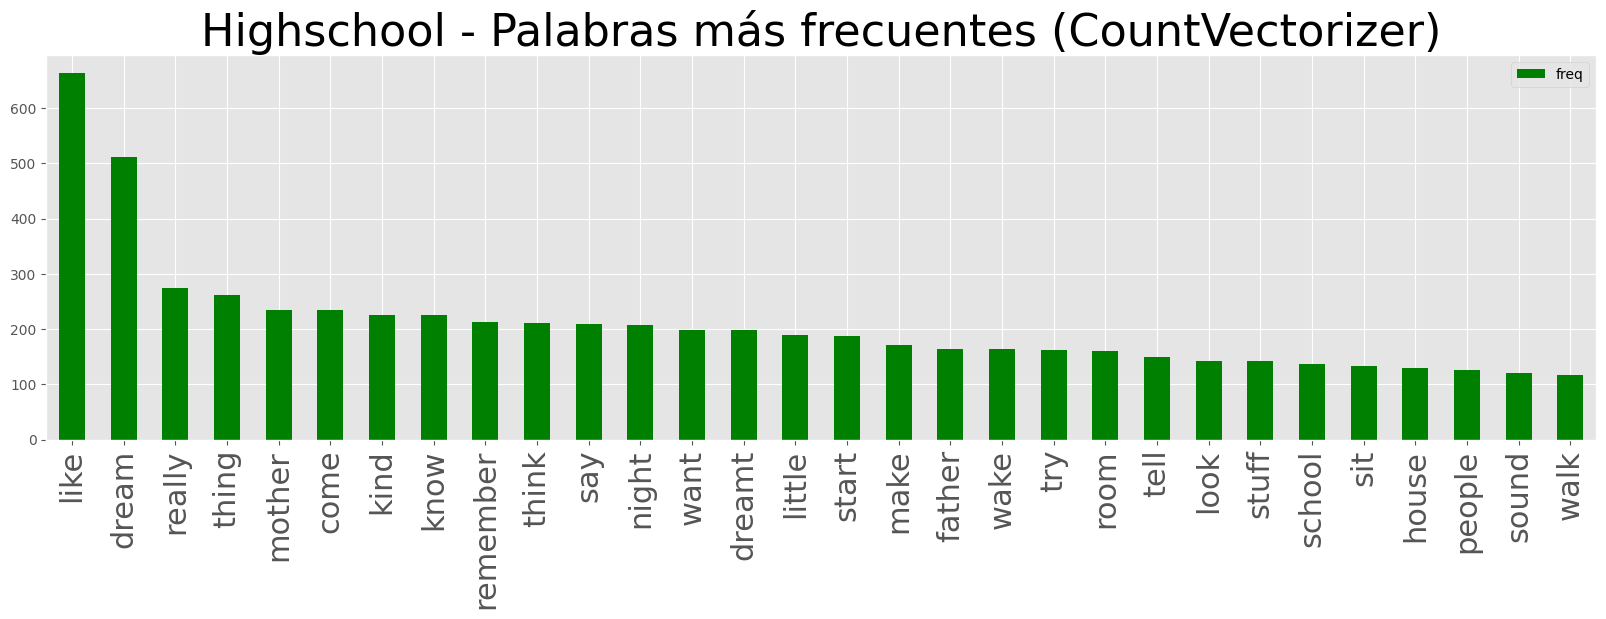

In [10]:
visualize_word_freq(highschool_files,30,"Highschool",tfidf=False,color='green')

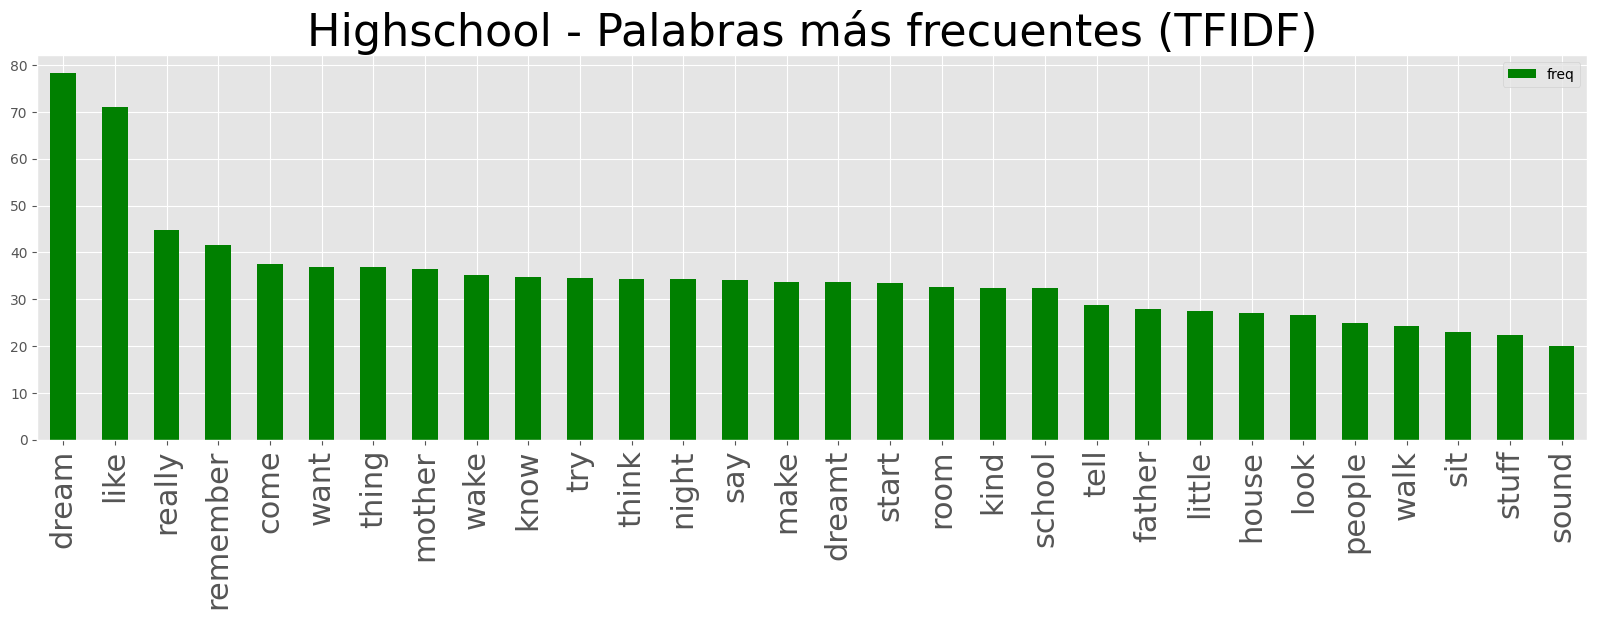

In [11]:
visualize_word_freq(highschool_files,30,"Highschool",tfidf=True,color='green')

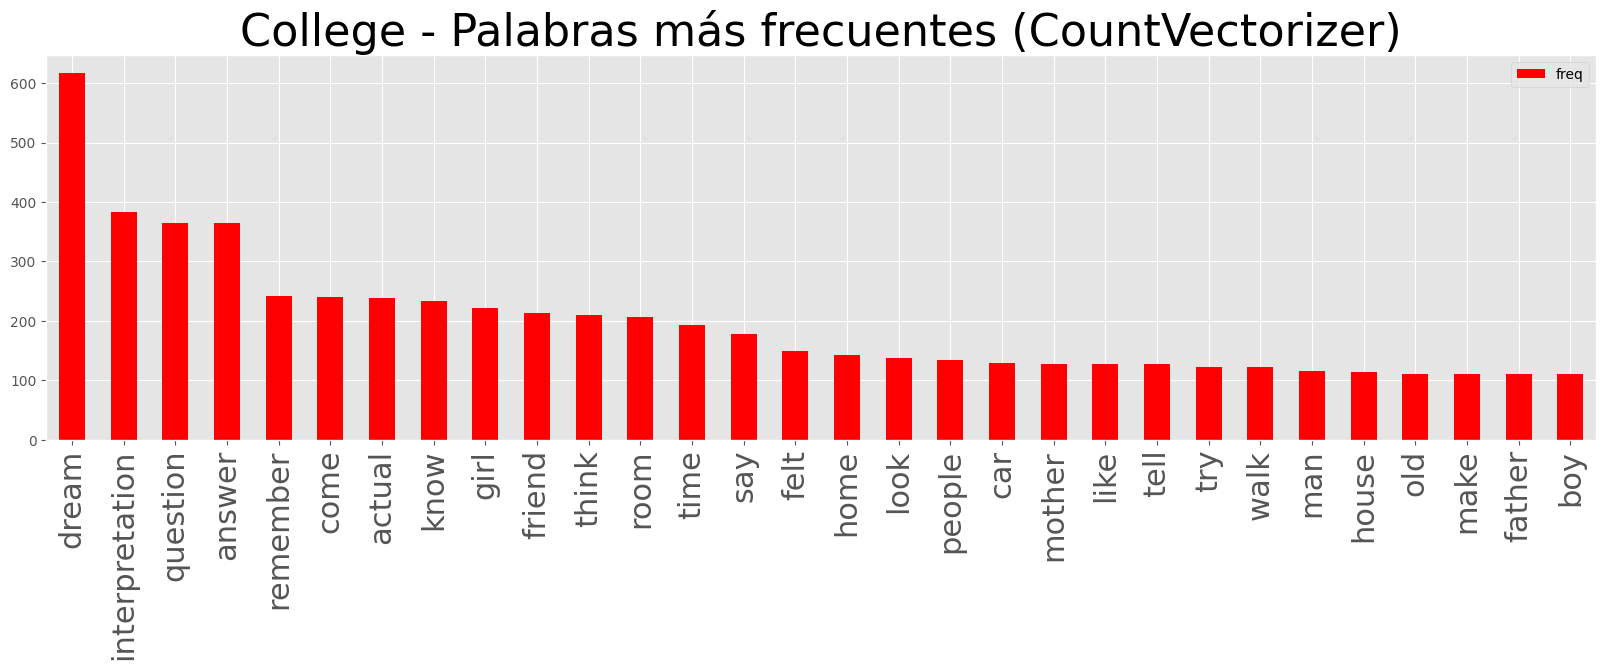

In [12]:
visualize_word_freq(college_files,30,"College",tfidf=False,color='red')

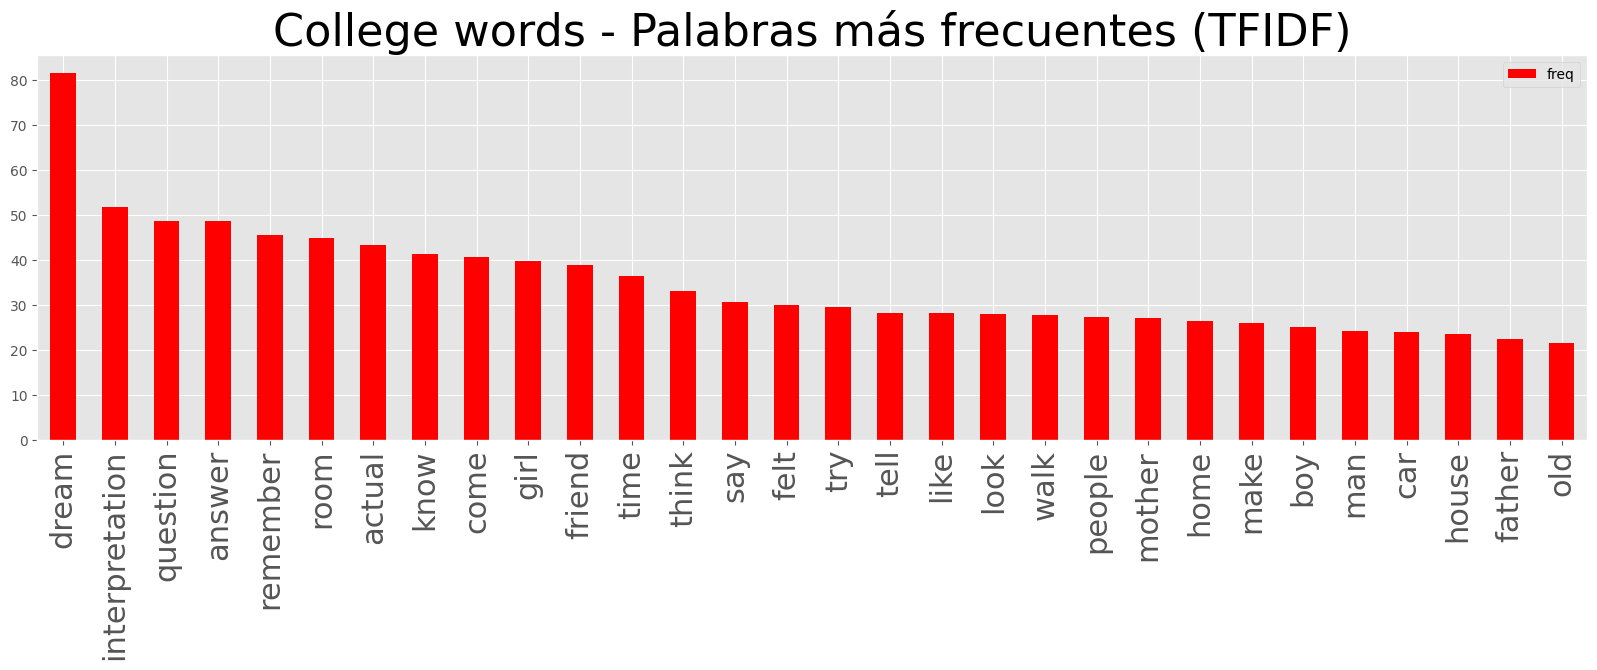

In [13]:
visualize_word_freq(college_files,30,"College words",tfidf=True,color='red')

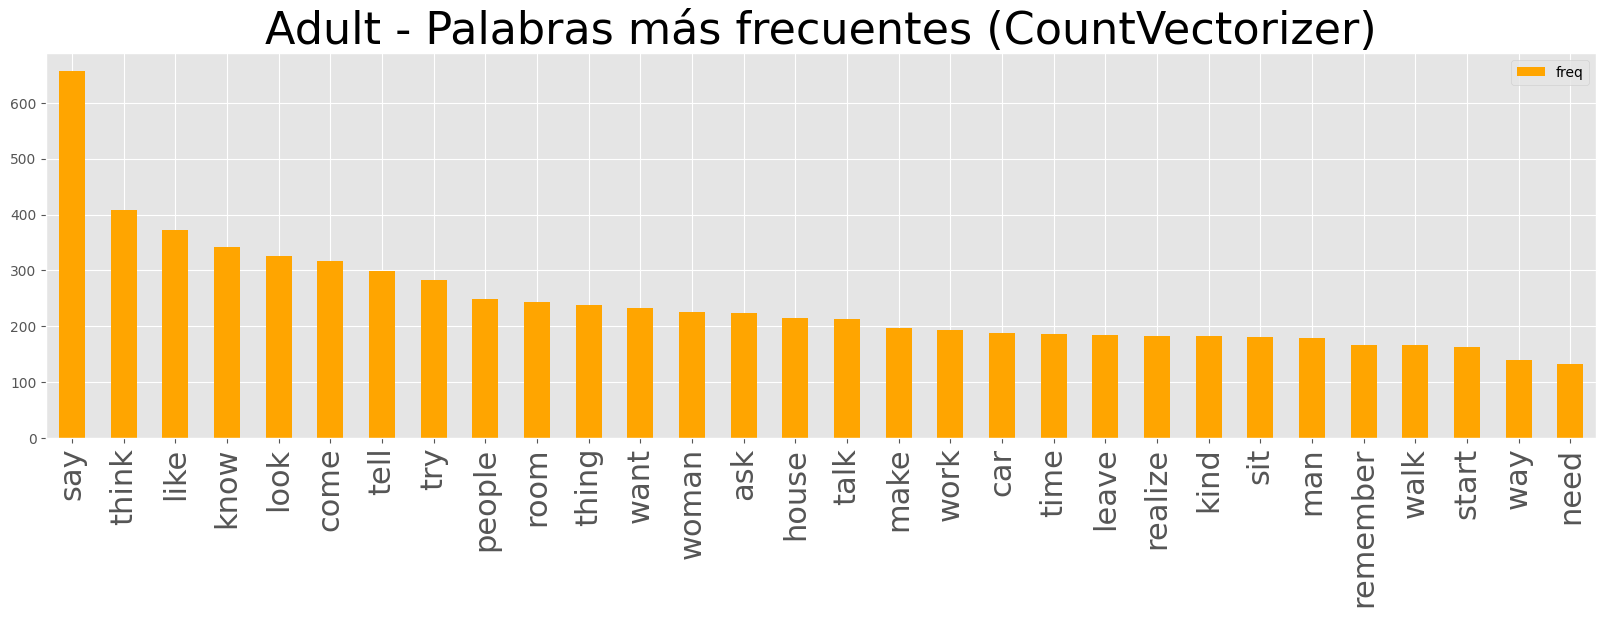

In [14]:
visualize_word_freq(adult_files,30,"Adult",tfidf=False)

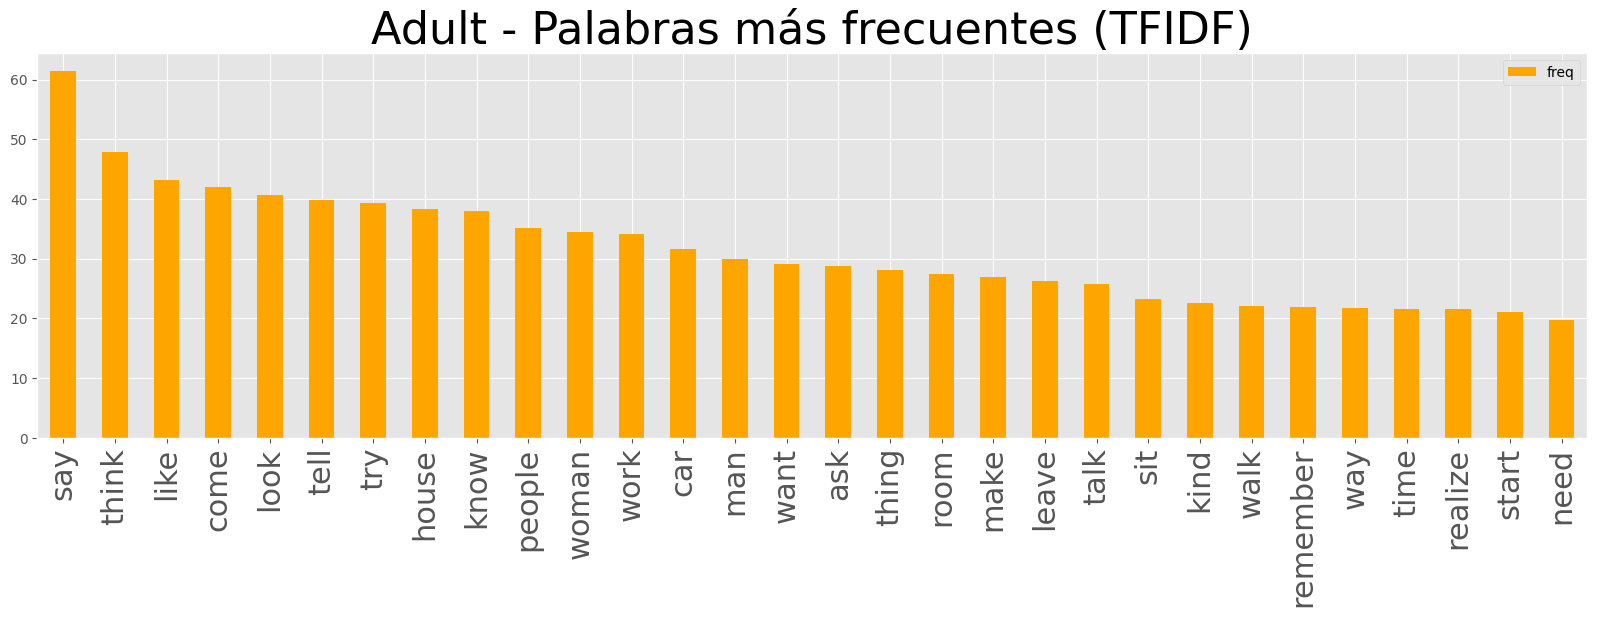

In [15]:
visualize_word_freq(adult_files,30,"Adult",tfidf=True)

# Similitud entre textos

In [37]:
# Sacamos la media de la similitud
similarity_matrix = cosine_similarity(tv_matrix)
similarity_df = pd.DataFrame(similarity_matrix)

mean_sim = 0
for i in range(0,400):
    mean_sim+= similarity_df.iloc[:,i].sort_values(ascending=False).reset_index(drop=True)[1]
mean_sim/400

0.2207328645348407

In [38]:
similarity_df

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
0,1.000000,0.092155,0.003414,0.013198,0.016811,0.034541,0.022226,0.000000,0.013581,0.037436,...,0.017555,0.049766,0.035038,0.003190,0.048176,0.059667,0.010363,0.024751,0.016885,0.002590
1,0.092155,1.000000,0.008383,0.033044,0.104595,0.049738,0.076375,0.033718,0.024666,0.081579,...,0.038363,0.048785,0.057753,0.026138,0.105590,0.076923,0.044561,0.031456,0.069827,0.007025
2,0.003414,0.008383,1.000000,0.021618,0.031083,0.014104,0.019929,0.017124,0.000000,0.019322,...,0.027174,0.005615,0.037984,0.007110,0.013167,0.005345,0.050048,0.031901,0.013242,0.006835
3,0.013198,0.033044,0.021618,1.000000,0.072835,0.040759,0.003620,0.043214,0.000000,0.039863,...,0.020746,0.033901,0.069314,0.013961,0.041172,0.040706,0.048273,0.042216,0.033024,0.006639
4,0.016811,0.104595,0.031083,0.072835,1.000000,0.054612,0.091715,0.006709,0.068023,0.089285,...,0.054226,0.145700,0.109028,0.040011,0.118265,0.002094,0.093591,0.139662,0.041263,0.020400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.059667,0.076923,0.005345,0.040706,0.002094,0.052081,0.019636,0.029335,0.000000,0.015643,...,0.019505,0.026756,0.047357,0.009711,0.010684,1.000000,0.015280,0.003879,0.002663,0.017261
396,0.010363,0.044561,0.050048,0.048273,0.093591,0.049849,0.054627,0.014832,0.014313,0.072343,...,0.038863,0.141941,0.115165,0.043949,0.089111,0.015280,1.000000,0.073476,0.030823,0.030746
397,0.024751,0.031456,0.031901,0.042216,0.139662,0.062936,0.042081,0.021019,0.114962,0.084184,...,0.045763,0.107136,0.098737,0.100836,0.128108,0.003879,0.073476,1.000000,0.028996,0.024567
398,0.016885,0.069827,0.013242,0.033024,0.041263,0.047911,0.027415,0.008531,0.007121,0.058165,...,0.056901,0.052944,0.065871,0.127382,0.119854,0.002663,0.030823,0.028996,1.000000,0.006810


# Estudiando los Topics

In [18]:
tv_list = tv_matrix.tolist()

In [19]:
from nltk.tokenize import word_tokenize

# Datos de los que queremos aprender
corpus_untok = full_data.iloc[:,0]

# tokenización
tokenized_corpus = [word_tokenize(i) for i in corpus_untok.tolist()]

diccionario = Dictionary(tokenized_corpus)

#diccionario.filter_extremes(no_below=2, no_above = 0.8) # si queremos filtrar palabras extremas

# Creamos el corpus 
corpus = [diccionario.doc2bow(texto) for texto in tokenized_corpus]
model = LdaModel(corpus=corpus, id2word=diccionario, 
        num_topics=50, random_state=42, 
        chunksize=1000, passes=10, alpha='auto')
        
topicos = model.print_topics(num_words=5, num_topics=20)
for topico in topicos:
    print(topico)

(30, '0.010*"clockwise" + 0.000*"direction" + 0.000*"pin" + 0.000*"five" + 0.000*"say"')
(9, '0.045*"cemetery" + 0.006*"silent" + 0.006*"butler" + 0.003*"grave" + 0.003*"blanket"')
(32, '0.169*"attorney" + 0.032*"treat" + 0.024*"closed" + 0.018*"others" + 0.017*"hit"')
(3, '0.033*"barb" + 0.028*"photo" + 0.020*"maze" + 0.020*"replace" + 0.020*"colored"')
(21, '0.022*"airplane" + 0.022*"aaron" + 0.021*"plane" + 0.020*"barbara" + 0.018*"cleaning"')
(42, '0.046*"foster" + 0.031*"bet" + 0.031*"location" + 0.026*"court" + 0.022*"read"')
(44, '0.126*"bus" + 0.028*"aisle" + 0.025*"across" + 0.021*"trim" + 0.021*"curve"')
(47, '0.076*"aunt" + 0.065*"balloon" + 0.050*"stop" + 0.042*"cap" + 0.027*"contest"')
(7, '0.049*"driver" + 0.043*"train" + 0.029*"avoid" + 0.028*"onto" + 0.023*"bart"')
(16, '0.085*"candy" + 0.042*"bag" + 0.037*"ticket" + 0.019*"money" + 0.019*"present"')
(38, '0.031*"ask" + 0.023*"say" + 0.016*"thing" + 0.015*"book" + 0.015*"tell"')
(6, '0.027*"say" + 0.015*"talk" + 0.013*"

In [23]:
from nltk.tokenize import word_tokenize

# Datos de los que queremos aprender
corpus_untok = highschool_files

# tokenización
tokenized_corpus = [word_tokenize(i) for i in corpus_untok.tolist()]

diccionario = Dictionary(tokenized_corpus)

#diccionario.filter_extremes(no_below=2, no_above = 0.8) # si queremos filtrar palabras extremas

# Creamos el corpus 
corpus = [diccionario.doc2bow(texto) for texto in tokenized_corpus]
model = LdaModel(corpus=corpus, id2word=diccionario, 
        num_topics=50, random_state=42, 
        chunksize=1000, passes=10, alpha='auto')
        
topicos = model.print_topics(num_words=5, num_topics=20)
print("High school topics:")
for topico in topicos:
    print(topico)

High school topics:
(36, '0.000*"girl" + 0.000*"jeremy" + 0.000*"like" + 0.000*"home" + 0.000*"white"')
(34, '0.017*"go" + 0.017*"clothes" + 0.017*"bra" + 0.017*"wear" + 0.009*"dream"')
(41, '0.024*"like" + 0.023*"sound" + 0.021*"salad" + 0.017*"get" + 0.015*"father"')
(37, '0.020*"would" + 0.013*"come" + 0.013*"think" + 0.013*"make" + 0.013*"hug"')
(30, '0.025*"cd" + 0.014*"wait" + 0.013*"dion" + 0.011*"celine" + 0.010*"go"')
(31, '0.022*"world" + 0.017*"mother" + 0.017*"save" + 0.011*"try" + 0.011*"shop"')
(40, '0.040*"jackson" + 0.020*"know" + 0.020*"play" + 0.015*"dream" + 0.013*"kiss"')
(1, '0.021*"take" + 0.017*"something" + 0.013*"like" + 0.012*"get" + 0.012*"proctor"')
(47, '0.021*"like" + 0.021*"parade" + 0.017*"sit" + 0.017*"go" + 0.017*"make"')
(18, '0.025*"dream" + 0.021*"hockey" + 0.018*"game" + 0.018*"asleep" + 0.017*"brother"')
(25, '0.033*"like" + 0.022*"little" + 0.022*"go" + 0.019*"dream" + 0.017*"mother"')
(49, '0.024*"go" + 0.015*"get" + 0.011*"hannah" + 0.010*"like

In [30]:
from nltk.tokenize import word_tokenize

# Datos de los que queremos aprender
corpus_untok = college_files

# tokenización
tokenized_corpus = [word_tokenize(i) for i in corpus_untok.tolist()]

diccionario = Dictionary(tokenized_corpus)

#diccionario.filter_extremes(no_below=2, no_above = 0.8) # si queremos filtrar palabras extremas

# Creamos el corpus 
corpus = [diccionario.doc2bow(texto) for texto in tokenized_corpus]
model = LdaModel(corpus=corpus, id2word=diccionario, 
        num_topics=5, random_state=42, 
        chunksize=1000, passes=10, alpha='auto')
        
topicos = model.print_topics(num_words=5, num_topics=20)
print("College topics:")
for topico in topicos:
    print(topico)

College topics:
(0, '0.012*"go" + 0.012*"dream" + 0.009*"interpretation" + 0.009*"answer" + 0.009*"question"')
(1, '0.016*"dream" + 0.011*"interpretation" + 0.010*"question" + 0.010*"answer" + 0.009*"take"')
(2, '0.015*"dream" + 0.010*"one" + 0.009*"question" + 0.009*"answer" + 0.008*"interpretation"')
(3, '0.020*"dream" + 0.012*"one" + 0.011*"interpretation" + 0.011*"go" + 0.011*"question"')
(4, '0.018*"dream" + 0.017*"get" + 0.015*"go" + 0.012*"interpretation" + 0.011*"answer"')


In [ ]:
# Probamos con un texto de prueba para ver a qué topico lo asocia
preprocesado = wp.WordPrep()
texto_test = "I was playing at the park with my mom and dad"
texto_test = preprocesado.corpus_text_preprocessing(texto_test)
texto_test = word_tokenize(texto_test)
texto_test
bow_texto_nuevo = diccionario.doc2bow(texto_test)

In [ ]:
# Indices de los topicos mas significativos
dist_indices = [topico[0] for topico in model[bow_texto_nuevo]]
# Contribucion de los topicos mas significativos
dist_contrib = [topico[1] for topico in model[bow_texto_nuevo]]
dist_indices

[1, 8, 10, 18, 19, 20, 26, 27, 46]

,Topico,Contribucion
0,19,0.190976
1,10,0.189683
2,8,0.189079


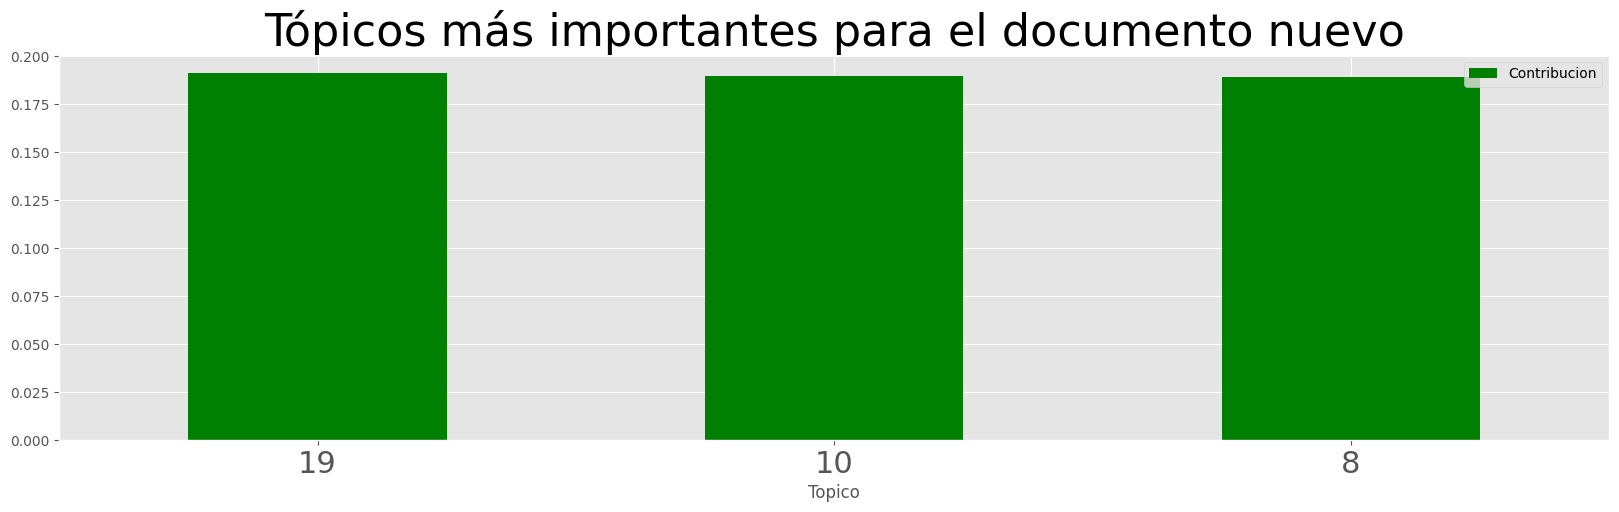

In [ ]:
distribucion_topicos = pd.DataFrame({'Topico':dist_indices,
                                     'Contribucion':dist_contrib})
distribucion_topicos.sort_values('Contribucion', 
                                 ascending=False, inplace=True)
distribucion_topicos = distribucion_topicos.reset_index(drop=True)
distribucion3_topicos = distribucion_topicos.loc[:2,:]
ax = distribucion3_topicos.plot.bar(y='Contribucion',x='Topico', 
                                   rot=0, color="green",
                                   title = 'Tópicos más importantes ' 
                                   'para el documento nuevo')
distribucion_topicos.loc[:2,:]

In [ ]:
for ind, topico in distribucion3_topicos.iterrows():
    print("*** Tópico: " + str(int(topico.Topico)) + " ***")
    palabras = [palabra[0] for palabra in model.show_topic(
        topicid=int(topico.Topico))]
    palabras = ', '.join(palabras)
    print(palabras, "\n")

*** Tópico: 19 ***
brother, mother, home, get, law, father, house, try, tell, come 

*** Tópico: 10 ***
get, town, boy, back, something, say, street, road, walk, hometown 

*** Tópico: 8 ***
train, card, room, ball, nurse, around, la, kind, responsible, new 



In [ ]:
# Proobamos un texto nuevo: Lo clasifica correctamente
texto_test_cat = "I was playing at the park with my mom and dad"
model_mulnb.predict([preprocesado.corpus_text_preprocessing(texto_test_cat)])

array([0])